<a href="https://colab.research.google.com/github/Aman-Verma-2307/User-Identification-using-Tweet-Analytics/blob/master/User_Identification_using_Tweet_Analytics_Case_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Threshold for selecting the dataset
__The user to be selected for training must satisfy ALL of the following thresholds:__
- Total number of tweets must be greater than or equal to 2,500
- Total words typed by the user must be greater than or equal to 20,000
- Average words per tweet for the user must be greater than or equal to 7
  
  
A total of about 1k users satisfied these criteria. The dataset contains the tweets of all these users. Dataset is available at:  
[https://github.com/Rutvik-Trivedi/files.git](https://github.com/Rutvik-Trivedi/files.git) with the name ```cleaned_data.tar.xz```

In [0]:
# Remove all unwanted files to free up space
!rm -rf sample_data

In [0]:
# Set the GloVe Embedding vector length. Available are: 25, 50, 100 and 200
glove_embedding_length = 200

# Get GloVe files
!mkdir glove
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip -d glove/

# Download dataset
!wget --no-hsts https://github.com/Rutvik-Trivedi/files/blob/master/cleaned_data_139.tar.xz?raw=true
!mv cleaned_data_139.tar.xz?raw=true dataset.tar.xz
# Unzip the Dataset
!tar -xf dataset.tar.xz

--2020-05-24 02:35:26--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2020-05-24 02:35:26--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2020-05-24 02:35:27--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [appli

In [0]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [0]:
l = os.listdir('cleaned_data/')
train_X = []
train_y = []

for user in l:
  tweets = pd.read_csv('cleaned_data/'+user)
  tweets.dropna(inplace=True, axis=0)
  train_X+=tweets['tweets'].tolist()
  train_y+=[user.strip('.csv')]*len(tweets)

assert len(train_X)==len(train_y), 'Error in structuring data. Please recheck the code'

In [0]:
maxlen = -1
for i in train_X:
  try:
    if len(i.split()) > maxlen:
      maxlen = len(i.split())
  except:
    pass

max_len = 280
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
sequences = tokenizer.texts_to_sequences(train_X)
pad_seq = pad_sequences(sequences, maxlen=max_len, padding='post')

vocab_size = len(tokenizer.word_index)+1

In [0]:
# Create GloVe Embeddings
embedding_vector = {}
glove_embedding_length = 200

f = open('glove/glove.twitter.27B.'+str(glove_embedding_length)+'d.txt')
for line in f:
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

embedding_matrix = np.zeros((vocab_size,glove_embedding_length))
for word,i in tokenizer.word_index.items():
        embedding_value = embedding_vector.get(word)
        if embedding_value is not None:
            embedding_matrix[i] = embedding_value
f.close()

In [0]:
### One Hot Encoding 

encoder = LabelEncoder()
encoder.fit(train_y)
train_y = encoder.transform(train_y)
train_y = tf.one_hot(np.array(train_y),139)

In [0]:
### Saving Dataset 
train_X = np.asarray(pad_seq)
train_y = np.asarray(train_y)

np.savez_compressed('train_X_final.npz',train_X)
np.savez_compressed('train_y_final.npz',train_y)

In [0]:
### Loading train_X and train_y

train_X = (np.load('/content/train_X_final.npz')['arr_0'])
train_y = (np.load('/content/train_y_final.npz')['arr_0'])

In [12]:
##### Model Case-1:LSTM 
max_len = 280
output = 139

model_11 = tf.keras.models.Sequential()
model_11.add(Input(shape=(max_len,)))
model_11.add(tf.keras.layers.Embedding(vocab_size, glove_embedding_length, weights=[embedding_matrix], trainable=False))
model_11.add(tf.keras.layers.LSTM(256,activation='tanh'))
model_11.add(tf.keras.layers.BatchNormalization())
model_11.add(tf.keras.layers.Dense(128,activation='relu'))
model_11.add(tf.keras.layers.BatchNormalization())
model_11.add(tf.keras.layers.Dense(output,activation='softmax'))

model_11.compile(tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model_11.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 200)          32302400  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               467968    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 139)               17931     
Total params: 32,822,731
Trainable params: 519,563
Non-trainable params: 32,303,168
______________________________________

In [13]:
### Model - Deep LSTM

model_12 = tf.keras.models.Sequential()
model_12.add(Input(shape=(maxlen,)))
model_12.add(tf.keras.layers.Embedding(vocab_size, glove_embedding_length, weights=[embedding_matrix], trainable=False))
model_12.add(tf.keras.layers.LSTM(128,activation='tanh',return_sequences= False))
model_12.add(tf.keras.layers.BatchNormalization())
model_12.add(Dense(512,activation='relu'))
model_12.add(Dense(output,activation='softmax'))

model_12.compile(tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_12.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 68, 200)           32302400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 139)               71307     
Total params: 32,608,715
Trainable params: 306,059
Non-trainable params: 32,302,656
_________________________________________________________________


In [14]:
### Model Bi-LSTM

model_13 = tf.keras.models.Sequential()
model_13.add(Input(shape=(maxlen,)))
model_13.add(tf.keras.layers.Embedding(vocab_size, glove_embedding_length, weights=[embedding_matrix],trainable=False))
model_13.add(tf.keras.layers.Bidirectional(LSTM(128,activation='tanh',return_sequences=False),merge_mode='concat'))
model_13.add(tf.keras.layers.BatchNormalization())
model_13.add(tf.keras.layers.Dense(512,activation='relu'))
model_13.add(Dense(output,activation='softmax'))

model_13.compile(tf.keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_13.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 68, 200)           32302400  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               336896    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 139)               71307     
Total params: 32,843,211
Trainable params: 540,299
Non-trainable params: 32,302,912
_________________________________________________________________


In [15]:
### Model-Deep Bi-LSTM

model_14 = tf.keras.models.Sequential()
model_14.add(Input(shape=(maxlen,)))
model_14.add(tf.keras.layers.Embedding(vocab_size, glove_embedding_length, weights=[embedding_matrix], trainable=False))
model_14.add(tf.keras.layers.Bidirectional(LSTM(128,activation='tanh',return_sequences=True),merge_mode='concat'))
model_14.add(tf.keras.layers.Bidirectional(LSTM(256,activation='tanh',return_sequences=False),merge_mode='concat'))
model_14.add(tf.keras.layers.BatchNormalization())
model_14.add(tf.keras.layers.Dense(768,activation='relu'))
model_14.add(tf.keras.layers.BatchNormalization())
model_14.add(tf.keras.layers.Dense(output,activation='softmax'))

model_14.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_14.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 68, 200)           32302400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 68, 256)           336896    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1050624   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 768)               393984    
_________________________________________________________________
batch_normalization_5 (Batch (None, 768)               3072      
_________________________________________________________________
dense_7 (Dense)              (None, 139)              

In [0]:
##### Case-II - Generative Pre Trained Networks 

In [0]:
### Model Pretraining 

train_y_gpt = train_X

model_prt = tf.keras.models.Sequential()
model_prt.add(tf.keras.Embedding(vocab_size, glove_embedding_length, weights=[embedding_matrix], trainable=False,input_shape=(max_len,)))
model_prt.add(tf.keras.LSTM(128,activation='tanh'))
model_prt.add(tf.keras.layers.BatchNormalization())
model_prt.add(tf.keras.Dense(256,activation='relu'))
model_prt.add(tf.keras.LSTM(glove_embedding_length))

In [0]:
#import random
#from sklearn.model_selection import train_test_split
#temp = list(zip(pad_seq, train_y))
#random.shuffle(temp)
#pad_seq, train_y = zip(*temp)
X, test_X, y, test_y = train_test_split(pad_seq, train_y, test_size=0.2) 

In [0]:
### Shuffling Arrays

from sklearn.utils import shuffle
X,y = shuffle(train_X,train_y)

In [0]:
### Training Set
X_train = X[:400000]
y_train = y[:400000]

### Dev Set
X_dev = X[400000:430000]
y_dev = y[400000:430000]

### Test Set
X_test = X[430000:]
y_test = y[430000:]

In [18]:
import gc
del(X,y)
gc.collect()

17

In [0]:
#  Train the model
history = model_11.fit(X_train,y_train,batch_size=64,epochs=100)

Epoch 1/100
6250/6250 [==============================] - 269s 43ms/step - loss: 4.9345 - accuracy: 0.0071
Epoch 2/100
6250/6250 [==============================] - 269s 43ms/step - loss: 4.9344 - accuracy: 0.0072
Epoch 3/100
6250/6250 [==============================] - 268s 43ms/step - loss: 4.3231 - accuracy: 0.0318
Epoch 4/100
6250/6250 [==============================] - 268s 43ms/step - loss: 3.9129 - accuracy: 0.0564
Epoch 5/100
6250/6250 [==============================] - 268s 43ms/step - loss: 3.8222 - accuracy: 0.0618
Epoch 6/100
6250/6250 [==============================] - 267s 43ms/step - loss: 3.7611 - accuracy: 0.0661
Epoch 7/100
6250/6250 [==============================] - 268s 43ms/step - loss: 3.7248 - accuracy: 0.0690
Epoch 8/100
6250/6250 [==============================] - 270s 43ms/step - loss: 3.7820 - accuracy: 0.0735
Epoch 9/100
6250/6250 [==============================] - 270s 43ms/step - loss: 3.7689 - accuracy: 0.0888
Epoch 10/100
6250/6250 [======================

dict_keys(['loss', 'accuracy'])


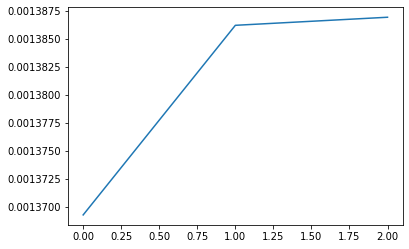

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.show()
plt.savefig('baseline_lstm(100)_accuracy.png')

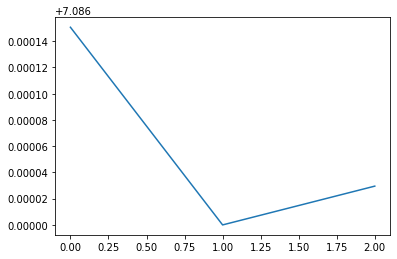

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['loss'])
plt.show()
plt.savefig('baseline_lstm(100)_loss.png')

# Possible reasons of Failure
- To large size of output vector (about 1k users)
- Model not optimized

# Experimentations
- Trying with a different Baseline Model